# Spam Detection Filter: Building a Text Classifier using NLP with Python 

## Dataset

We will be using the [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection), currently maintained at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). This is a public set of SMS labeled messages that have been collected for mobile phone spam research. See the included `readme` file for more information.

We are going to use this dataset to build a spam detection filter with Python. Once downloaded and stored in a folder of choice, we can read the data in and get a list of all the text messages as follows:

In [6]:
messages = [line.rstrip() for line in open('data/smsspamcollection')]
print(len(messages))

5574


Let us see what some lines in the dataset look like.

In [7]:
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [8]:
messages[2]

"spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

Notice that the first word of each line is either **ham** or **spam**, followed by a tab character (`\t`). This dataset is a **tab-separated values** (TSV) **file**. A TSV file is a simple text format for storing data in a tabular structure.

- The first column is the **text message label** (either ham or spam, where ham is a message that is not spam; that is, "non-spam" or a "good message").
- The second column is the **text message** itself.

Now let us enumerate the messages and print the first 5.

In [9]:
for num, message in enumerate(messages[:5]):
    print("{}]  {}".format(num+1, message))

1]  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
2]  ham	Ok lar... Joking wif u oni...
3]  spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
4]  ham	U dun say so early hor... U c already then say...
5]  ham	Nah I don't think he goes to usf, he lives around here though


Using these *labeled text messages*, the goal is to build a predictive, machine learning model which will determine automatically whether a new text message is ham or spam. Once the model is trained to learn to discriminate between the two labels, it can be used to classify arbitrary unlabeled text messages as ham or spam.

Instead of parsing the TSV file manually using Python, we can use `pandas` to read the file contents into a **pandas dataframe**.

In [10]:
import pandas as pd
messages_df = pd.read_csv('data/smsspamcollection', sep='\t', names=['label', 'text'])
messages_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysys

Let us do now some *exploratory data analysis* of our data. First, get some statistical information about the data.

In [11]:
messages_df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Here we see a few things:

- There are 2 unique lables, as expected.
- The number of unique messages (5169) is less than the total number of messages (5572). This means that there are repeated messages.
- The most common text message is "Sorry, I'll call later", which is labeled as ham.

Now we can use the `describe()` method on the messages grouped by 'label'. This allow us to start thinking about the **features** that separate a ham from a spam. [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge to extract features from raw data via data mining techniques. The better your domain knowledge on the data, the better your ability to engineer more features from it and the higher the performance of the machine learning algorithm can be.

In [12]:
messages_df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

This gives us a few more details:

- There are 4825 ham messages vs. 747 spam messages, including repeated values.
- The most common ham message is again "Sorry, I'll call later", while the most common spam message is "Please call our customer service...".

Now let us make a new column to see how long text messages are: 

In [13]:
messages_df['len'] = messages_df['text'].apply(len)
messages_df.head()

,label,text,len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


We can use the `matplotlib` library to obtain a distribution of *text message length*.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1.0, 'Distribution of Text Message Length')

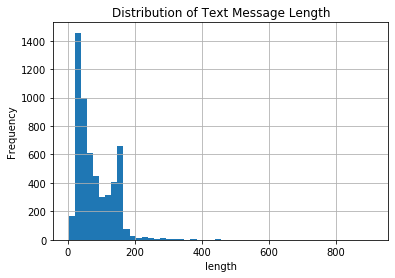

In [15]:
# messages['len'].plot(bins=50, kind='hist')
messages_df['len'].plot.hist(bins=50).grid()
plt.xlabel("length")
plt.title("Distribution of Text Message Length")

Let us now get some stats about *text message length* to see what is going on.

In [16]:
messages_df['len'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: len, dtype: float64

We can see that the shortest text message has 2 characters and the longest has 910 characters. We can retrieve the *shortest* and *longest* text messages as follows:

In [17]:
# messages_df[messages_df['len'] == 2]['text']
messages_df[messages_df['len'] == min(messages_df['len'])]['text']

1925    Ok
3051    Ok
4498    Ok
5357    Ok
Name: text, dtype: object

In [18]:
# messages_df[messages_df['len'] == 910]['text']
messages_df[messages_df['len'] == max(messages_df['len'])]['text']

1085    For me the love should start with attraction.i...
Name: text, dtype: object

We can see the entire longest string as follows:

In [19]:
messages_df[messages_df['len'] == max(messages_df['len'])]['text'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Let us see if *text message length* is a distinguishing feature between ham and spam.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e264950>,
      dtype=object)

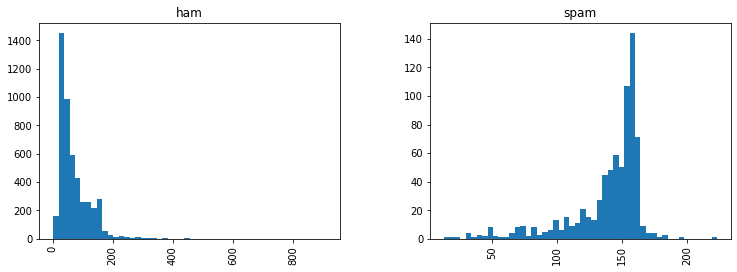

In [20]:
messages_df.hist(column='len', by='label', bins=50, figsize=(12,4))

These plots indicate that spam messages tend to have more characters.

Now let us see the corresponding statistics. 

In [21]:
messages_df[messages_df['label'] == 'ham'].describe()

,len
count,4825.000000
mean,71.482487
std,58.440652
min,2.000000
25%,33.000000
50%,52.000000
75%,93.000000
max,910.000000


In [22]:
messages_df[messages_df['label'] == 'spam'].describe()

,len
count,747.000000
mean,138.670683
std,28.873603
min,13.000000
25%,133.000000
50%,149.000000
75%,157.000000
max,223.000000


We see that *ham message length* is centered around 52, while *spam message length* is centered around 149. Hence, **it looks like length is a good feature to distinguish ham messages from spam messages**. The next step is to pre-process the data so we can use it to do machine learning with Python using `scikit-learn`.

## Text Pre-processing

Classification algorithms require a numerical feature vector to perform the classification task. There are many methods to convert a corpus of strings to a vector format, but the simplest one is the [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model), where the (frequency of) occurrence of each (unique) word is used as a feature for training a classifier. Since our data is all in text format, we want to convert the raw messages (*sequence of strings*) into numerical vectors (*sequence of numbers*). The process of converting NLP text into numbers is called **[vectorization](#Vectorization)**.

Let us write a function that will split a message into its individual words and return a list of significant words. First we need to remove punctuation characters and then filter out very common words, also known as *stopwords*. First we examine the individual components and then we build the function.

Let us get a sample message.

In [23]:
sample = messages_df['text'][20]
sample

'Is that seriously how you spell his name?'

Then remove punctuation (see [string](https://docs.python.org/3/library/string.html)).

In [51]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [35]:
sample_np = [char for char in sample if char not in string.punctuation]
sample_np = ''.join(sample_np)
sample_np

'Is that seriously how you spell his name'

In [36]:
sample_np.split()

['Is', 'that', 'seriously', 'how', 'you', 'spell', 'his', 'name']

To remove stopwords, install NLTK (`conda install nltk`), import the library, and then use one of NLTK's data downloaders to [install NLTK Data](https://www.nltk.org/data.html). For central installation, change the download directory to `C:\nltk_data` (Windows), `/usr/local/share/nltk_data` (Mac), or `/usr/share/nltk_data` (Unix). Next, select the packages or collections you want to download. In this case, we want to download the **Stopwords Corpus**.

In [37]:
import nltk

In [38]:
# nltk.download()   # A new window should open, showing the NLTK Downloader. 
                    # Click on the File menu, select Change Download Directory, 
                    # find the corpus, download it, and close the window.

In [39]:
# nltk.download_shell()       # Type 'd', then 'enter', and then 'stopwords' to 
                              # download the StopWords corpus.

In [40]:
# nltk.download('stopwords')  # Download corpus directly to default download 
                              # directory.

In [41]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [31]:
sample_np_nsw = [word for word in sample_np.split() if word.lower() not in stopwords.words('english')]
sample_np_nsw

['seriously', 'spell', 'name']

We can now write a function to pre-process any given text.

In [47]:
# =============================================================================
def preprocess_text(text):
    """
    SciKit-Learn Analizer: 
    Does some kind of feature selection by performing the following actions 
    on the given string:
    1. Removes all punctuators.
    2. Removes all stopwords (insignificant words)
    3. Returns a list of significant words.
    """
    # Choose only characters that are not punctuators.
    text_np = [char for char in text if char not in string.punctuation]

    # Join the selected characters to form a string.
    text_np = ''.join(text_np)
    
    # Split the string into its individual words and return a list of
    # significant words.
    return [word for word in text_np.split() if word.lower() not in 
            stopwords.words('english')]

We can now use this function to *tokenize* all text messages in the dataframe. The process of converting a text string into a list of **tokens** (significant words) is called **tokenization**. 

In [48]:
messages_df_tok = messages_df['text'].apply(preprocess_text)
messages_df_tok.head()

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

Compare this result with the original dataframe.

In [49]:
messages_df.head()

,label,text,len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## Text Normalization

Removing punctuators and stopwords from a text is just one step of **text normalization**. **Normalization** is the process of converting a list of words to a more uniform sequence. There are many other ways to continue normalizing, including [Stemming](https://en.wikipedia.org/wiki/Stemming) and [Categorizing and Tagging Words](http://www.nltk.org/book/ch05.html) (for example, by parts of speech). Some methods might work well for text messages, while others might not due to the presence of abbreviations, shorthand, or slang in messages, such as "Nah", "dawg", "IDK", "Wut", "da", etc.

The [(Natural Language Toolkit) NLTK 3.4.5 documentation](https://www.nltk.org/index.html) and the [Natural Language Processing with Python book](http://www.nltk.org/book/) are great resources to explore and learn about more advanced methods. The book also provides a practical introduction to programming for language processing and guides readers through the fundamentals of writing Python programs, working with corpora, categorizing text, analyzing linguistic structure, and more.